# Part 1

## Components

In [1]:
from langchain_ollama import ChatOllama

model = ChatOllama(
    model = "qwen3",
    temperture = 0
)

In [2]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model = "nomic-embed-text")

In [3]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Indexing

#### Loading Documents

In [6]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [7]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


#### Splitting Documnets

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


#### Storing Documents

In [11]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['4a60532e-c5f9-4d54-bb70-f5cc350a2a3a', '33c9ecfd-40d6-4868-b77a-d5be3d2b63db', 'c170a67d-6939-4372-b192-f6c63921353c']


## Retrieval and Generation

In [14]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

C:\Users\ASUS\miniconda3\envs\Ollama\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [15]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [16]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}

In [17]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

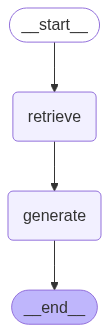

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='c170a67d-6939-4372-b192-f6c63921353c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth

In [21]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='c170a67d-6939-4372-b192-f6c63921353c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can

In [22]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

<think>|
|Okay|,| the| user| is| asking| about| Task| Decom|position|.| Let| me| look| through| the| provided| context| to| find| the| answer|.

|The| context| mentions| that| Task| Decom|position| is| a| method| to| break| down| complex| tasks| into| smaller|,| manageable| steps|.| It| references| Chain| of| Thought| (|Co|T|)| and| Tree| of| Thoughts| as| techniques| where| models| think| step| by| step| or| explore| multiple| reasoning| paths|.| Also|,| there| are| methods| like| using| L|LM| prompts|,| task|-specific| instructions|,| and| even| external| planners| like| L|LM|+|P|.| 

|I| need| to| summarize| this| in| three| sentences|.| First|,| define| Task| Decom|position|.| Then| mention| the| main| techniques| like| Co|T| and| Tree| of| Thoughts|.| Finally|,| note| other| approaches| like| prompting| and| external| planners|.| Make| sure| it|'s| concise| and| within| the| limit|.
|</think>|

|Task| decomposition| is| a| method| to| break| down| complex| tasks| into| smaller|,| 

In [23]:
# result = await graph.ainvoke(...)

# async for step in graph.astream(...):

In [24]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

## Query Analysis

In [25]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [26]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [27]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [31]:
class State(TypedDict):
    question: str
    query: Search ########################################################################
    context: List[Document]
    answer: str


def analyze_query(state: State): #########################################################
    structured_llm = model.with_structured_output(Search) ################################
    query = structured_llm.invoke(state["question"]) #####################################
    return {"query": query} ##############################################################


def retrieve(state: State):
    query = state["query"] ###############################################################
    retrieved_docs = vector_store.similarity_search( #####################################
        query["query"], ##################################################################
        filter=lambda doc: doc.metadata.get("section") == query["section"], ##############
    ) ####################################################################################
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate]) ######
graph_builder.add_edge(START, "analyze_query") ###########################################
graph = graph_builder.compile()

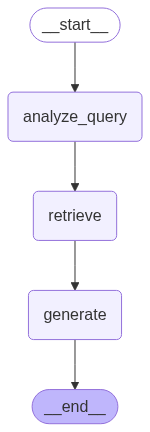

In [32]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'What does the end of the post say about Task Decomposition?', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='179fffc6-c818-48fb-8c8f-1a0e7963fd5b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 32858, 'section': 'end'}, page_content='}\n]\nThen after these clarification, the agent moved into the code writing mode with a different system message.\nSystem message:'), Document(id='ef26690a-a078-434a-b1ef-da098aca2653', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 30868, 'section': 'end'}, page_content='Here are a sample conversation for task clarification sent to OpenAI ChatCompletion endpoint used by GPT-Engineer. The user inputs are wrapped in {{user input text}}.\n[\n  {\n    "role": "system",\n    "content": "You will read instructions and not carry them out, only seek to clarify them.\\nSpecifically you will first summarise a

# Part 2

In [14]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model = "qwen3",
    temperture = 0
)

In [15]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model = "nomic-embed-text")

In [16]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Chains

In [17]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [18]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [19]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [20]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [21]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [22]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

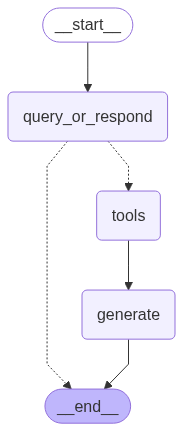

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

<think>
Okay, the user said "Hello". I need to respond appropriately. Since there's no specific query here, maybe they just want a greeting. The tools provided are for retrieving information, but a simple hello doesn't require any function calls. I should just reply with a friendly message. Let me check the tools again to make sure. The retrieve function is for queries, but this is a general greeting. So no tool call needed. I'll respond with a welcome message.
</think>

Hello! How can I assist you today?


In [25]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

<think>
Okay, the user is asking, "What is Task Decomposition?" I need to figure out how to respond. Let me start by recalling what I know about task decomposition. It's a concept often used in project management, AI, and robotics. Breaking down a complex task into smaller, manageable sub-tasks. But I should make sure I get the details right.

Wait, the user might be looking for a definition, maybe examples, or its applications. Since I'm supposed to use the provided tools, I should check if the 'retrieve' function can help get accurate information. The function requires a query parameter. The user's question is straightforward, so I can use the retrieve function with the query "What is Task Decomposition?" to get the necessary information. That way, the answer will be based on reliable data. Let 

### Stateful management of chat history

In [26]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [27]:
input_message = "Hello I am Majid"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello I am Majid
================================== Ai Message ==================================

<think>
Okay, the user said, "Hello I am Majid." Let me think about how to respond. First, I need to acknowledge their greeting. Since they introduced themselves as Majid, I should greet them back and maybe offer assistance. The tools provided include a retrieve function, but in this case, the user isn't asking for information. They're just introducing themselves. So, no need to call any functions here. Just a friendly response to welcome Majid and ask how I can help him today. Keep it simple and polite.
</think>

Hello, Majid! Welcome. How can I assist you today? 😊


In [28]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

<think>
Okay, the user asked, "What is Task Decomposition?" I need to provide a clear and accurate answer. Let me start by recalling what task decomposition means. From what I remember, it's a process of breaking down a complex task into smaller, more manageable subtasks. But I should make sure to get the details right.

First, I should define task decomposition simply. Then, maybe explain why it's useful. People use it to make tasks less overwhelming, right? It's common in project management, software development, and even everyday problem-solving. 

Wait, should I mention specific methodologies or frameworks that use task decomposition? Like Agile or Waterfall? Or maybe examples would help. For instance, if someone is building a website, they might decompose the task into designing the layout, c

In [29]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================

<think>
Okay, the user asked, "Can you look up some common ways of doing it?" referring to task decomposition. Let me start by recalling the previous conversation. The user was explained task decomposition, and the assistant provided info from a source about methods like Chain of Thought (CoT), Tree of Thoughts, and LLM+P with PDDL. Now the user wants to know common ways.

First, I need to check if there's existing information in the history that can answer this. The previous tool call retrieved content mentioning three main approaches: simple prompting, task-specific instructions, human input, and LLM+P with PDDL. Also, CoT and Tree of Thoughts were highlighted as techniques. 

The user is asking for "common ways," so I should list the most frequently used methods. The answer sh

## Agents

In [30]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

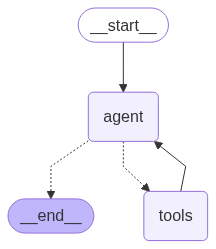

In [31]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [32]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================

<think>
Okay, the user is asking about the standard method for Task Decomposition. Let me start by recalling what task decomposition is. It's a process of breaking down a complex task into smaller, more manageable sub-tasks. The standard method might involve techniques like breaking down tasks into steps, using hierarchies, or maybe something like the WBS (Work Breakdown Structure) in project management.

Wait, but I should verify this. Let me use the retrieve function to get accurate information. The first step is to find the standard method. So I'll call the retrieve function with the query "standard method for Task Decomposition". 

Once I get that information, the user wants to know the common extension